Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [59]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [142]:
#rStart = np.concatenate([np.linspace(6.1, 6.18, 5), np.linspace(6.225, 6.245, 5)])[None, :]
#phiStart = np.linspace(0, 2 * np.pi, 5, endpoint = False)[:,None]
rStart = np.asarray([6.19] + [6.225, 6.235, 6.245] * 5)
phiStart = np.asarray(
    [0] +
    [0 * 2 * np.pi / 5] * 3 + [1 * 2 * np.pi / 5] * 3 + [2 * 2 * np.pi / 5] * 3 + [3 * 2 * np.pi / 5] * 3 + [4 * 2 * np.pi / 5] * 3
)


xStart = rStart * np.cos(phiStart)
yStart = rStart * np.sin(phiStart)
zStart = 0 * xStart

Now it's time to run our calculation.

In [143]:
pos, ax = fsc.flt.findAxis(field, startPoint = [xStart, yStart, zStart], islandM = 5, targetError = 1e-4, minStepSize = 1e-3, nTurns = 50)

In [144]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-4, minStepSize = 1e-3,
    islandM = 5, axis = ax
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

In [145]:
print(iotas.shape, rStart.shape)

(16,) (16,)


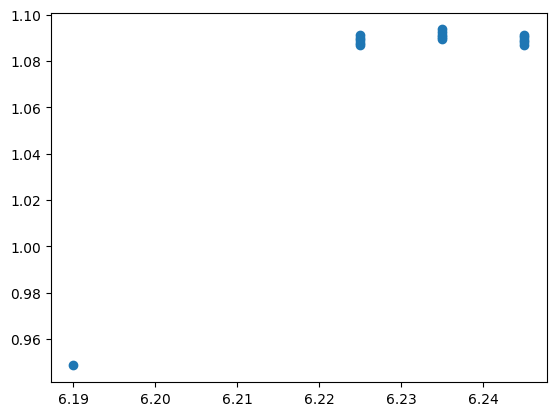

In [146]:
plt.scatter(rStart + 0 * phiStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [147]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    30, # Turn count
    nMax = 15, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 1,
    targetError = 1e-4, distanceLimit = 1e5, maxStepSize = 0.01,
    stellaratorSymmetric = False, aliasThreshold = 0.05, # The island surfaces are not Stellarator symmetric
    islandM = 5
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [148]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor', 'rSin', 'zCos'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [149]:
modes["iota"]

array([0.94894158, 1.08870277, 1.0903715 , 1.09210265, 1.08833475,
       1.09000711, 1.09173696, 1.08797141, 1.08964908, 1.09137329,
       1.08760838, 1.08928429, 1.09100997, 1.08725005, 1.08891646,
       1.09064819])

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [150]:
modes["theta"]

array([-0.01284739,  3.0889415 ,  3.08667024, -0.01028034, -1.86219494,
       -1.86151099,  1.32735791, -0.53068741, -0.52690188,  2.6641619 ,
        0.79986346,  0.80603591, -2.28320829,  2.12991531,  2.13764755,
       -0.94826154])

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

In [151]:
surfaces = modes["surfaces"]

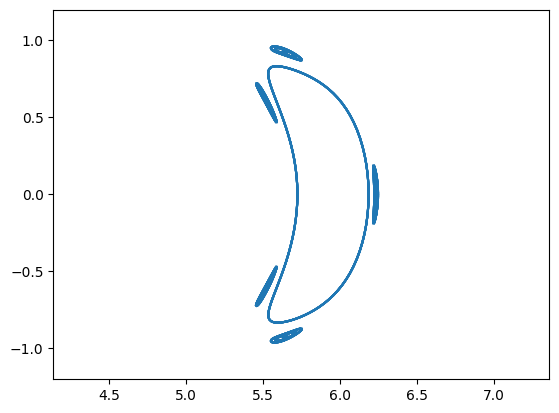

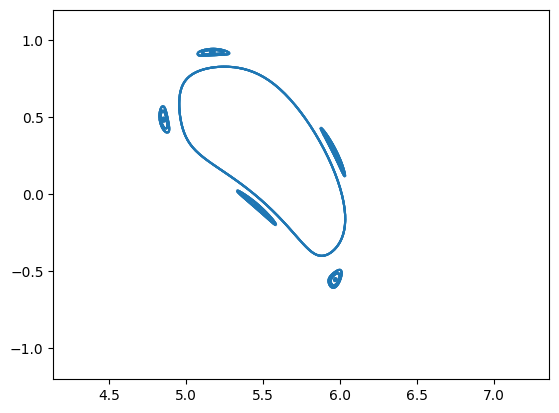

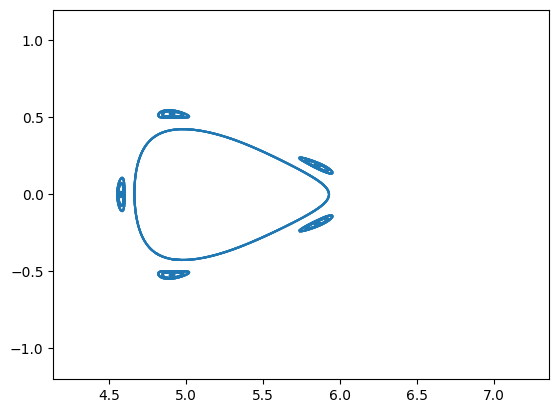

In [152]:
def plotCut(phi):
    plt.figure()
    surfaces.asGeometry().plotCut(np.radians(phi))
    plt.axis('equal')
    plt.xlim(5, 6.5)
    plt.ylim(-1.2, 1.2)

plotCut(0)
plotCut(18)
plotCut(36)

C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\_api_markers.py:15: UserWarning: The function fusionsc.magnetics.MagneticConfig.calculateRadialModes is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")
C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\magnetics.py:402: UserWarning: calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended
  warnings.warn("calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended")


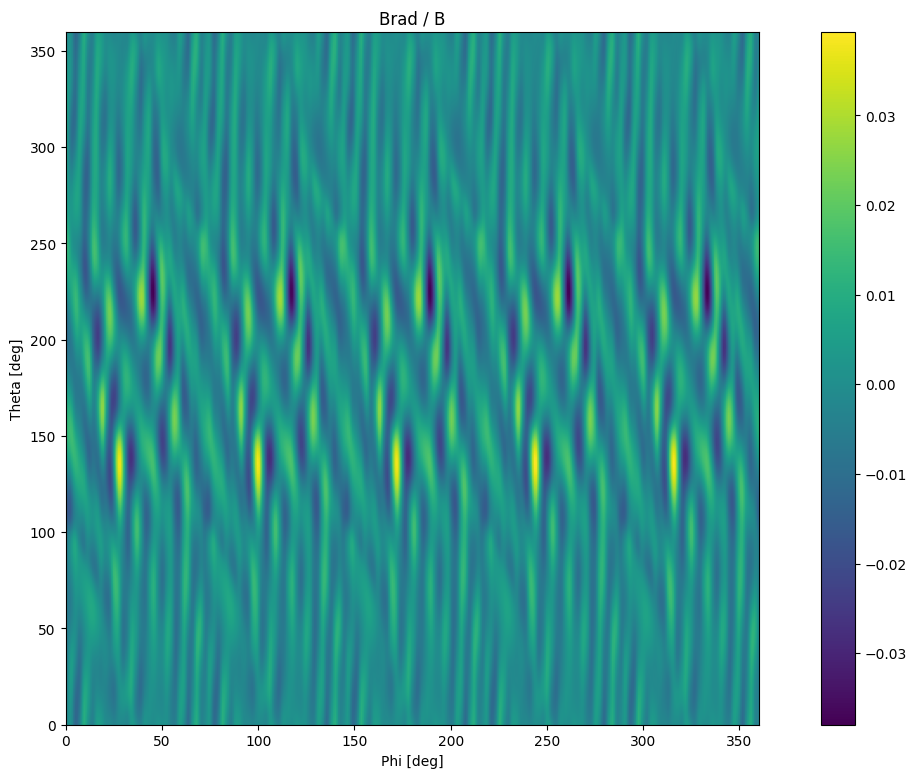

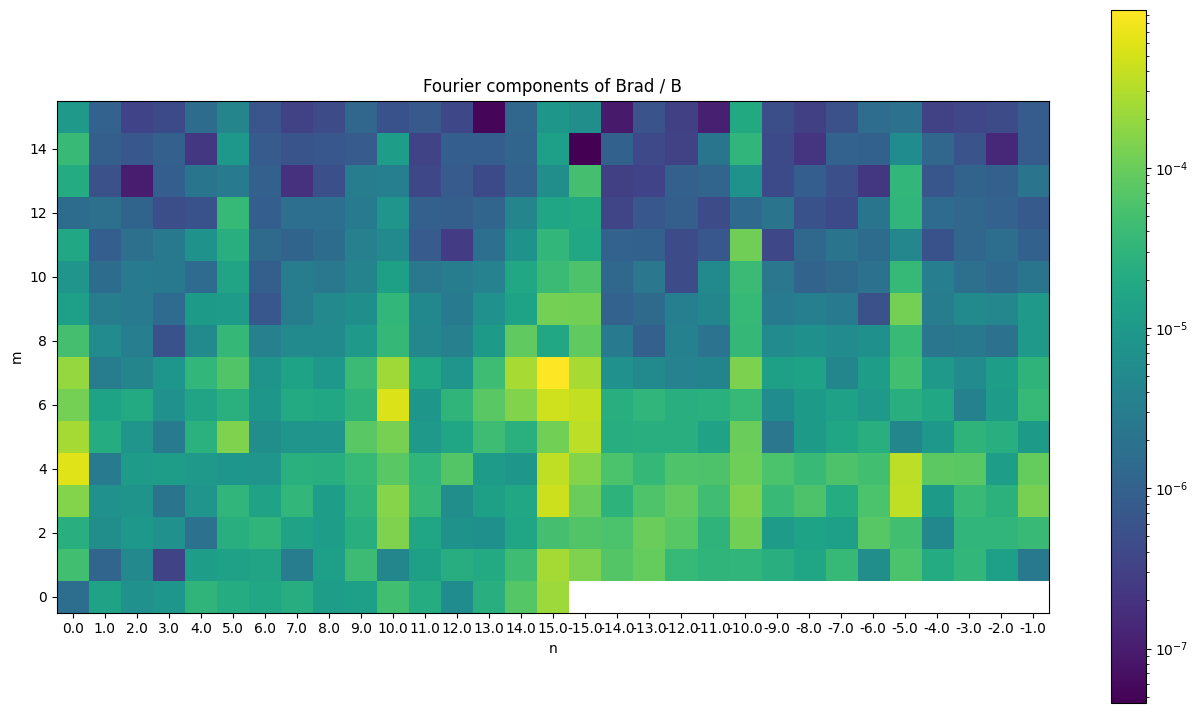

In [157]:
surf = surfaces[0]
#np.asarray(surf.data.rCos)[0,0] += 0.03

fieldModes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 15, nMax = 15, nTheta = 400, nPhi = 400)
cc = fieldModes["cosCoeffs"]
sc = fieldModes["sinCoeffs"]

m = fieldModes["mPol"]
n = fieldModes["nTor"]

phi = fieldModes["phi"]
theta = fieldModes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(fieldModes["radialValues"].T, origin='lower', extent = [0, 360, 0, 360])
plt.colorbar()
plt.title("Brad / B")
plt.xlabel('Phi [deg]')
plt.ylabel('Theta [deg]')

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

The calculated surfaces can also be converted into geometries to plot.

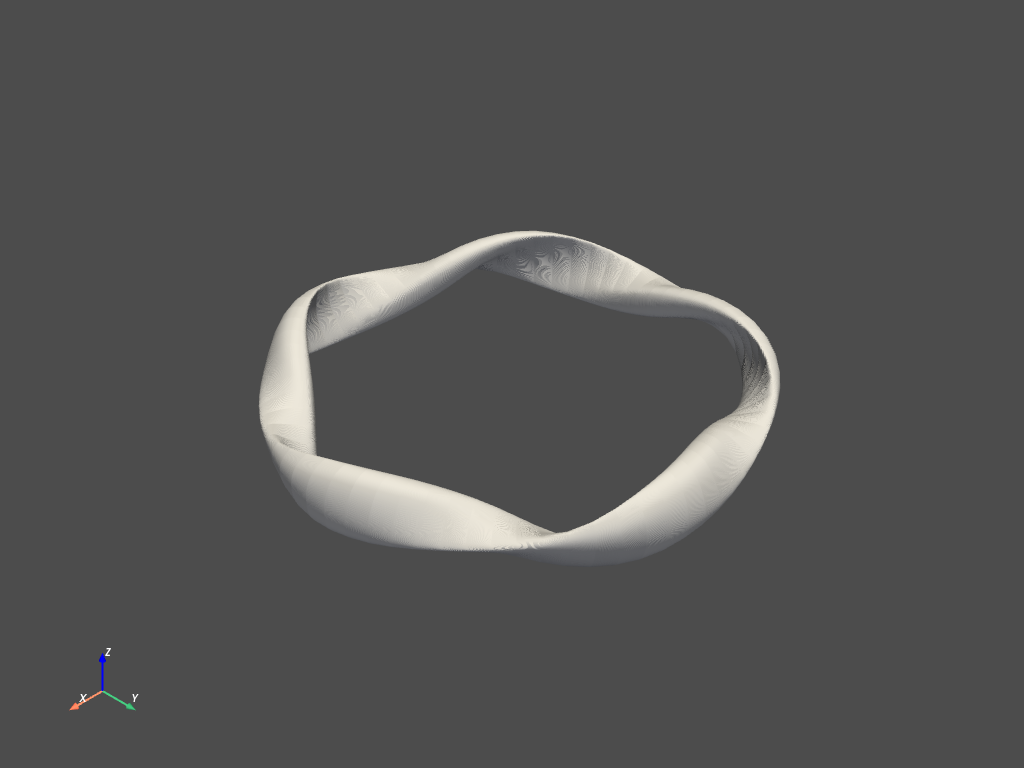

In [156]:
asPv = surfaces[0].asGeometry(nPhi = 360, nTheta = 360).asPyvista()
asPv.plot(jupyter_backend = 'static')